# Analysis of Algorithms 1: introduction to $O$ notation

## All code and notebooks can be found here: https://github.com/rimmera-elsevier/algorithm-analysis

## What is this about?
The idea is to give a high-level overview of the analysis of algorithmic complexity, with some examples of real-world algorithms in Python, and their asymptotic behaviour. I will skip over most of the mathematical details, but will introduce $O$ notation for describing runtime complexity.

## Why do I care about this?
Asymptotic analysis is a useful tool for analysing data processing problems, and is increasingly important for software development in a world of ever larger and more complex datasets. A good grasp of asymptotic complexity and $O$ notation will help you to

* Write better code, that runs faster and does not blow up running on large datasets
* Communicate with other developers, data scientists etc using a shared (industry standard) vocabulary
* Take advantage of future career opportunities - this subject comes up quite a lot in interviews

The subject is also interesting in its own right, and rewards much more detailed study than we have time for. In these talks I will mainly focus on those aspects most relevant to our work.

## Further reading

### For the more the casual reader
* Wikipedia: maybe start with https://en.wikipedia.org/wiki/Big_O_notation and read around
* Steven Skienna — The Algorithm Design Manual

### For the more mathematically inclined / people with lots of spare time
* Donald Knuth — Concrete Mathematics
* Donald Knuth — The Art of Computer Programming
* Cormen, Leiserson Rievest, Stein -- Introduction to Algorithms

## A motivating example: how long does it take to sort a list of numbers?

Let's try sorting a large list, say 1 million random floating point numbers...

In [4]:
import numpy
from algorithm_utils import time_function

one_million = 1000000
list_of_random_numbers = numpy.random.rand(one_million)
time_to_sort = time_function(numpy.sort, (list_of_random_numbers,))

print(f"It takes {time_to_sort:0.2f} ms to sort {one_million} random values")

It takes 0.09 ms to sort 1000000 random values


Ok, but this is not particularly useful; the value fluctuates depending on the exact set of random numbers generated and, unless we only ever want to sort arrays of 1 million values then we need more... what we really want to know is how does the run-time depend on the size ($N$) of the input array, so let's look at that...

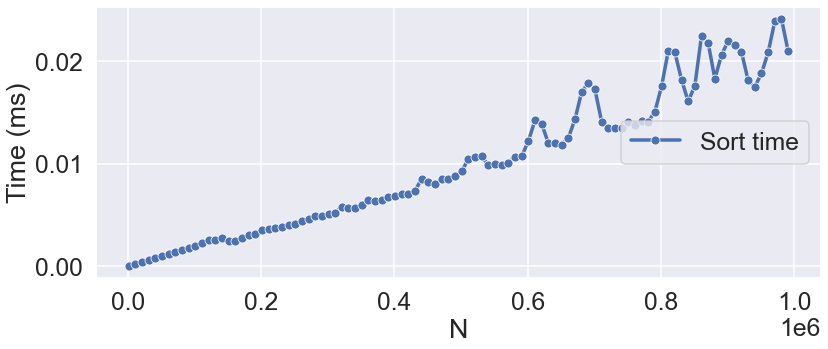

In [41]:
import numpy
import seaborn
import pandas
import matplotlib.pyplot as plt

seaborn.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 3.5})

from algorithm_utils import *

min_size = 1000
max_size = 1000000
increment = 10000
x_axis_label = "N"
y_axis_label = "Time (ms)"

lists = [
    numpy.random.rand(x) for x in range(min_size, max_size, increment)
]

list_lengths = [len(x) for x in lists]
sort_times = [time_function(numpy.sort, (x,)) for x in lists]

data = pandas.DataFrame({
    x_axis_label: list_lengths, 
    y_axis_label: normalize(sort_times)
})

plt.rcParams['figure.figsize'] = [13, 5]
seaborn.lineplot(x=x_axis_label, y=y_axis_label, data=data, marker='o')
plt.legend(labels=["Sort time"], loc="right");

Some obvious features of this graph:
* Sort-time increases with the size of the input array
* The relationship between size and sort-time looks fairly smooth for most of the graph, and is almost a straight line

**Q**: is there perhaps a mathematical relationship between $N$ and the sort-time?   
**A**: yes, but it's pretty complicated, and depends entirely on the details of the sort function

**Q**: is it possible to actually calculate the run-time from $N$ using some kind of equation?   
**A**: you don't want to see that equation... also no, not really, there are too many variables involved, and it is much easier to just run the function and time it than it is to construct a crazy equation like that.

**Q**: Ok, we can't get an exact calculation, but maybe we can describe the shape of the relationship? That would help us to see how sort-time depends on $N$?
**A**: we can do that, and there are some nice mathematical tools that will help us. Let's start by looking at a few simple mathematical relationships, and see if anything looks similar to our graph...

## Some standard mathematical functions that grow at different rates
### N.B. we are concerned here only with the shapes of the curves, not the absolute y-axis values, since these are all scaled to fit onto the same graph. The important thing is how fast the functions grow at large values of $N$.

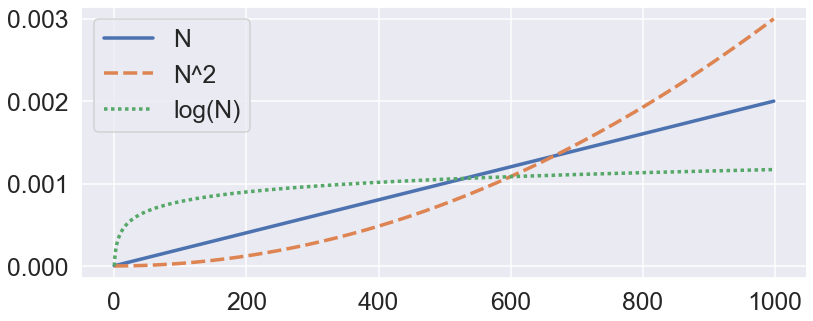

In [42]:
from math import log, exp

n_values = range(1, 1000)
n = normalize(n_values)
n_squared = normalize([n**2 for n in n_values])
log_n = normalize([log(n) for n in n_values])

data = pandas.DataFrame({
    "N": n, 
    "N^2": n_squared,
    "log(N)": log_n
})

plt.rcParams['figure.figsize'] = [13, 5]
seaborn.lineplot(data=data);

You can see from this graph that there is a clear difference in growth rate of these functions for large $N$. Specifically, $N^{2}$ grows faster than $N$ which grows faster than $log(N)$. Let's look at a few more standard functions...

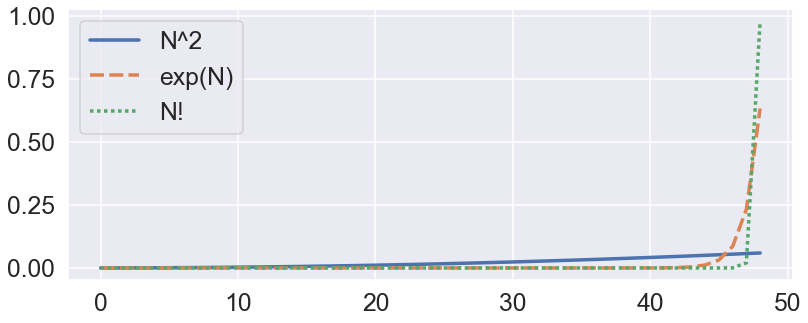

In [43]:
import seaborn
from math import log, factorial, exp

n_values = range(1, 50)

data = pandas.DataFrame({
    #"N": normalize(n_values), 
    "N^2": normalize([n**2 for n in n_values]),
    #"log(N)": normalize([log(n) for n in n_values]),
    "exp(N)": normalize([exp(n) for n in n_values]),
    "N!": normalize([factorial(n) for n in n_values]),
})

plt.rcParams['figure.figsize'] = [13, 5]
seaborn.lineplot(data=data);

It's tricky to plot these, as the factorial function grows so fast, but here you can see that, for large $N$, $N!$ grows faster than $e^{N}$, which grows faster than $N^{2}$. 

**Q**: So what's the point of looking at all these 'standard' functions?   
**A**: we want to have a standard vocabulary for describing how the run-times of algorithms grow as the input dataset gets larger, then we can compare different algorithms and also have a better idea about whether they will blow up on big datasets. We don't care about the details, just the overall behaviour at large $N$, so we can build a standard set of simple functions to compare against.

So far we have looked at, in increasing order of growth rate, $log(N)$, $N$, $N^{2]$, $e^{N}$ and $N!$. There are a couple of others worth looking at...

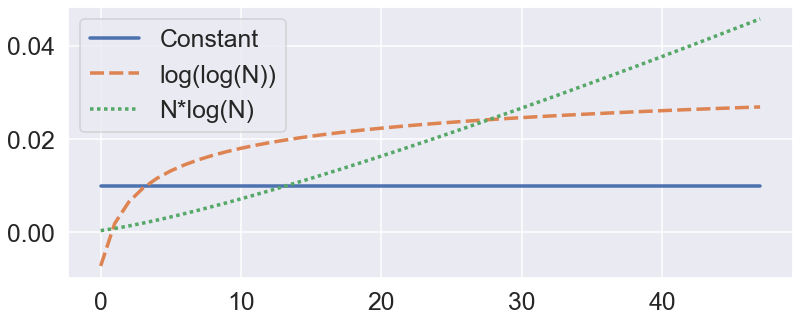

In [50]:
import seaborn
from math import log, factorial, exp

n_values = range(2, 50)

data = pandas.DataFrame({
    "Constant": [0.01 for n in n_values], 
    "log(log(N))": normalize([log(log(n)) for n in n_values]),
    "N*log(N)": normalize([n*log(n) for n in n_values]),
})

plt.rcParams['figure.figsize'] = [13, 5]
seaborn.lineplot(data=data);

Ok so now we have a decent list of standard functions, from the no-growth-at-all constant function to the more enthusiastic factorial function. Now we just need a standard syntax for referring to these, so we can use them to describe the rate of growth of real algorithm run-times.

## Introducing $O$ notation

Of course the standard syntax is big-Oh notation, which has become almost ubuquitous in the world of computational algorithms, thanks in part to its use by Donald Knuth in various books including the (still WIP) *The Art of Computer Programming*. $O$ is actually one of several measures used to describe the asymptotic behaviour of functions / algorithms: there is also $\Omega$, $o$, $\Theta$ and others, but we don't need to worry about those for now (or ever?).

The important thing to understand is that **$O$ describes an upper bound on the growth of a function at large N (i.e. as $N\to\infty$)** so when we say a function / algorithm is $O(N^{2})$ we mean that, in the worst case, the algorithm will grow as fast as $N^{2}$ for large $N$.

### Big-Oh notation for our standard functions, in ascending order of growth rate

* $O(1)$
* $O(log(log(N)))$
* $O(log(N))$
* $O(N)$
* $O(N log(N)$
* $O(N^{2})$
* $O(e^{N})$
* $O(N!)$

So how fast does our sorting function grow? Inspecting the graphs above shows that the growth is closest in shape to $O(N)$ and $O(Nlog(N))$. But we don't really need to plot graphs to know this, as sorting algorithms are a very well studied problem - the best comparison sort functions have a growth rate of $O(Nlog(N))$, and in fact this is a proven lower bound for comparison sorts. 

Ok, so now we have introduced $O$ notation and looked at some of the standard functions. That's probably enough for one day.

## Coming up in part 2: we look at some standard Python algorithms and data structures, and discuss their $O$ behaviour and how to accidentally blow up on large datasets...